![alt text](problem_definition.png "Problem definition")

![alt text](problem_variables.png "Problem variables")

<h1> Read graph from file </h1>

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# create graph G
file_name = 'GtsPoland.gml'
G = nx.read_gml(file_name)


# remove virtual nodes without location
nodes_without_location = []
for i in G.nodes:
    if not 'Latitude' in G.nodes[i]:
        nodes_without_location.append(i)
for i in nodes_without_location:
    G.remove_node(i)

# get longitude and latitude of nodes    
lat_dict = nx.get_node_attributes(G, 'Latitude')
lng_dict = nx.get_node_attributes(G, 'Longitude')

cities_dict = lat_dict.keys()

lat = list(lat_dict.values())
lng = list(lng_dict.values())
cities = list(lat_dict)

poss = {cities[i]:(lng[i], lat[i]) for i in range(0,len(lat))}

plt.rcParams['figure.figsize'] = [15,15]
nx.draw_networkx(G, pos=poss, with_labels=True, font_weight='bold')

<h1> Define constants and variables </h1>

In [2]:
# import random for generating capacity of controllers
rnd = np.random
rnd.seed()

K = 3        
V_count = len(G.nodes)      
V = [list(G.nodes).index(i) for i in G.nodes]      

theta = [i for i in range(0, K)]            
l_i = {i : rnd.randint(1, 10) for i in V}   

# generate different capacity values for controllers that sum up to the sum of capacity of all switches multiplied by a constant
L_values_for_theta = rnd.dirichlet(np.ones(K), size=1).flatten()*sum(l_i.values())*1.1
L  = {i : L_values_for_theta[i] for i in theta}

In [3]:
# vector of longitude for each node
V_loc_x = lng

# vector of latitude for each node
V_loc_y = lat

E = [(list(G.nodes).index(i),list(G.nodes).index(j)) for i, j in G.edges]  

# calculate the weight of each edge in graph as euclidean distance between two nodes
for i, j in G.edges:
    ii = list(G.nodes).index(i)
    jj = list(G.nodes).index(j)
    G[i][j]['weight'] = np.hypot(V_loc_x[ii] - V_loc_x[jj], V_loc_y[ii] - V_loc_y[jj])

# calculate matrix representing shortest distance between all nodes 
d =  nx.floyd_warshall_numpy(G, weight='weight')

# possibilities of placing controller theta in place of a switch v
TV = [(i, j) for i in theta for j in V]

# each node to each node dictionary
SV = [(s, v) for s in V for v in V]

<h1> Define decision variables, constraints and minimalization problem </h1>

<h4>Decision variables: </h4>

In [4]:
from docplex.mp.model import Model
mdl = Model('CCPP')

# binary dict of possibilities of placing controller theta in place of a node v
tv = mdl.binary_var_dict(TV, name="tv")

#binary dict if switch connected to controller in place v
sv = mdl.binary_var_dict(SV, name="sv")

<h4> Optimization problem:</h4>

In [5]:
# minimize max const of edge for given cluster
#mdl.minimize(mdl.max(d[i,j]*sv[i,j] for i,j in SV))

# or minimize average const
mdl.minimize((mdl.sum(d[i,j]*sv[i,j] for i,j in SV))/V_count)

<h4> Constraints:</h4>

In [6]:

# exactly k controllers
mdl.add_constraints(mdl.sum(tv[t,v] for v in V)==1 for t in theta)

# max one controller in one place
mdl.add_constraints(mdl.sum(tv[t,v] for t in theta)<=1 for v in V)

# one switch has only one link (link to controller)
mdl.add_constraint(mdl.sum(sv[i,j] for i, j in SV) == V_count )

mdl.add_constraints(mdl.sum(sv[i,j] for j in V) == 1 for i in V)

# if switch has active link, it must have controller at it's end
mdl.add_indicator_constraints(mdl.indicator_constraint(sv[i,j],mdl.sum(tv[t,j] for t in theta)==1) for i,j in SV)

# maximum capacity of a switch cannot be exceeded 
mdl.add_indicator_constraints(
    mdl.indicator_constraint(tv[t,v],mdl.sum(sv[i,j]*l_i[i] for i,j in SV if j==v)<=L[t]) for v in V for t in theta)


<h1> Solve problem </h1>

In [7]:
mdl.parameters.timelimit = 30
solution = mdl.solve()

(14.11922834767025, 23.58379165232975, 49.78725090654893, 54.690609093451066)

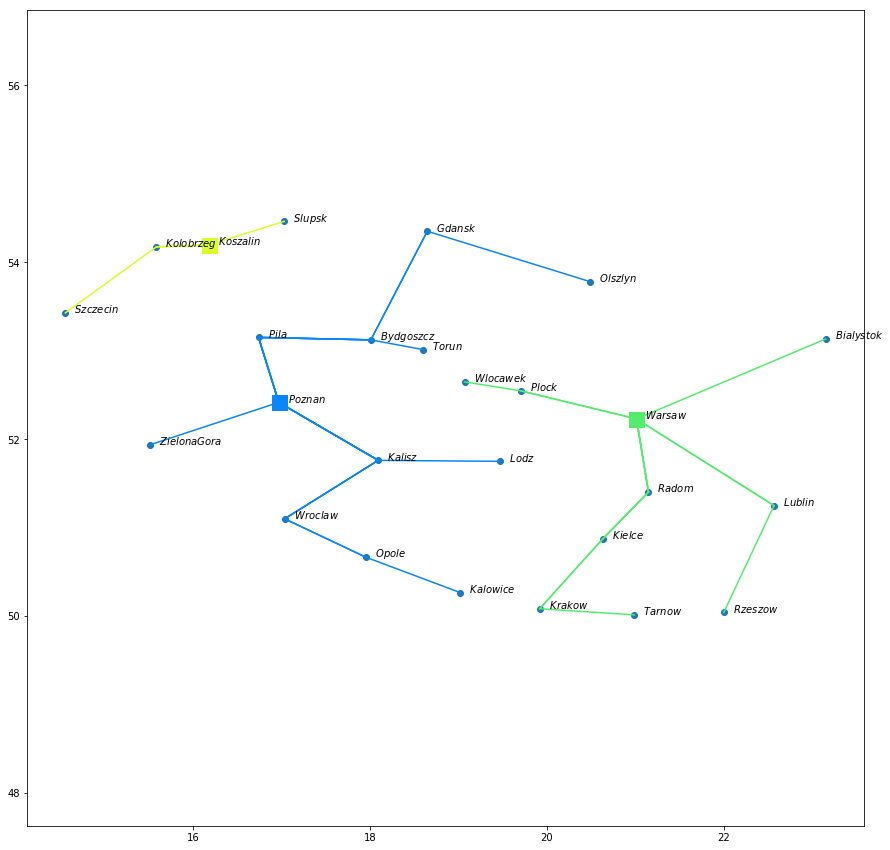

In [8]:
colors = {}
plt.rcParams['figure.figsize'] = [15,15]

active_arcs = [a for a in SV if sv[a].solution_value>0.9]


plt.scatter(V_loc_x[:], V_loc_y[:])
for i in V:
    plt.annotate('   $%s$' % (list(G.nodes)[i]), (V_loc_x[i], V_loc_y[i]))
for i,j in active_arcs:
    path = nx.shortest_path(G,list(G.nodes)[i], list(G.nodes)[j], 'weight')
    if not path[-1] in colors:
        colors[path[-1]] = np.random.rand(3,)
    
    for k in range(0, len(path)-1):
        vi = list(G.nodes).index(path[k])
        vj = list(G.nodes).index(path[k+1])
        plt.plot([V_loc_x[vi], V_loc_x[vj]], [V_loc_y[vi], V_loc_y[vj]],c = colors[path[-1]])
        if k == len(path)-2:
            plt.plot(V_loc_x[vj], V_loc_y[vj], c=colors[path[-1]], marker='s', markersize=15)
plt.axis('equal')

In [9]:
#create summary of each controller

theta_results = {}
for t in theta:
    theta_result = {'place': -1, 'switches': [], 'capacity_used': 0, 'capacity_max': L[t]}
    for v in V:
        if tv[t, v].solution_value > 0.9:
            theta_result['place'] = v
            break
            
    for i, j in active_arcs:
        if j == theta_result['place']:
            theta_result['switches'].append(i)
            theta_result['capacity_used']+=l_i[i]
            
    theta_results[t] = theta_result 
theta_results

{0: {'place': 21,
  'switches': [20, 21, 22, 23],
  'capacity_used': 16,
  'capacity_max': 19.513911007255516},
 1: {'place': 24,
  'switches': [4, 5, 8, 9, 11, 12, 13, 15, 18, 19, 24, 25],
  'capacity_used': 76,
  'capacity_max': 82.54132852422227},
 2: {'place': 0,
  'switches': [0, 1, 2, 3, 6, 7, 10, 14, 16, 17],
  'capacity_used': 35,
  'capacity_max': 37.644760468522236}}